## Data

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from pandasql import sqldf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
file_name = 'p-raw_data.csv'
df = pd.read_csv(f'../data/processed/{file_name}')

df['at'] = pd.to_datetime(df['at'])

## Analysis

### Games statistics

**1. What are the pot size distributions?**

In [ ]:
df['hand_id'].nunique()

Text(0.5, 0, 'log(Big blinds)')

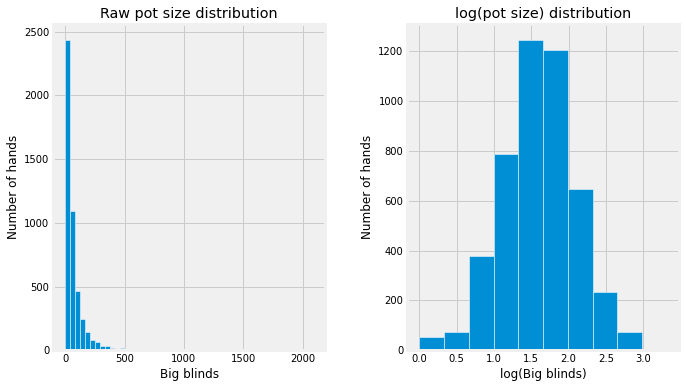

In [3]:
fig, axes = plt.subplots(1,2, figsize=(10, 6))
pot_sizes = df.groupby('hand_id')['pot_size'].max().sort_values(ascending=False) / 0.20


pot_sizes.to_frame().hist(ax=axes[0], ec='white', bins=50)
axes[0].set_title('Raw pot size distribution')
axes[0].set_ylabel('Number of hands')
axes[0].set_xlabel('Big blinds')

np.log10(pot_sizes).to_frame().hist(ax=axes[1], ec='white')
axes[1].set_title('log(pot size) distribution')
axes[1].set_ylabel('Number of hands')
axes[1].set_xlabel('log(Big blinds)')

The left chart (raw pot sizes) shows that the distribution is heavily skewed. It's easier to use log of pot size (right chart) and see that the median pot value is around 30x BB (~10**1.5)

**2. At which phases are the hands won?**

Judging from the result, we can conclude that the game was pretty casual as it often went to River. My hypothesis is that good players have better evaluation of their hands strength, hence they can make decisions earlier (eg. folding earlier). Meanwhile, at a lower stake game, player don't lose much in terms of dollar value hence it's ok to commit longer.

We can verify this by comparing hand end phase vs. a higher stake game.

Text(0.5, 0, 'Number of hands')

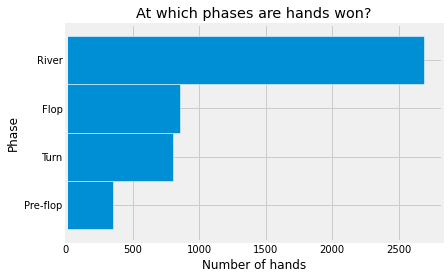

In [4]:
fig, ax = plt.subplots()
ax.clear()
df.loc[df['action']=='Won'].groupby('hand_id')['phase'].max().value_counts(dropna=False, ascending=True).plot(ax=ax, kind='barh', width=1, ec='white')
ax.set_title('At which phases are hands won?')
ax.set_ylabel('Phase')
ax.set_xlabel('Number of hands')

**3. How many pots were split?**

We can determine by counting the number of winners per hand

In [5]:
df.loc[df['action']=='Won']['hand_id'].value_counts().value_counts()

1    4576
2     114
3       5
4       1
Name: hand_id, dtype: int64

### Individual player statistics

**1. Overview:  Number of hands played, Winnings, Win per hand**

By itself number of hands played only shows how many hands the players sit in. But will be useful to calculate the various playstyle metrics below.

We can make a reasonable assumption that, given enough hands, the better players win more. Next we will analyse different patterns of behaviors. Hopefully we can learn from the winners here.

In [131]:
# pl = player dataframe to store all metrics
pl = df.loc[(df['phase']=='Pre-flop') & (df['rank-P0']==1)]['player_name'].value_counts(dropna=False).to_frame(name='num_hands_played')
_expenses = df.groupby('player_name')['put_in'].sum()
_expenses.name = 'total_expenses'


_income = df.loc[df['action']=='Won'].groupby('player_name')['_amount'].sum().sort_values()
_income.name = 'total_income'

pl = pl.merge(_income, left_index=True, right_index=True)
pl = pl.merge(_expenses, left_index=True, right_index=True)

pl['win/hand'] = (pl['total_income'] - pl['total_expenses']) / pl['num_hands_played']

pl.sort_values(by='win/hand', ascending=False).head(5)

,num_hands_played,total_income,total_expenses,win/hand
8n7u_1IqWV,56,206.85,114.45,1.650000
87_zNFIhfU,34,113.40,76.90,1.073529
24uSa0Jg9V,39,143.30,101.63,1.068462
6KDaksPWKW,1346,2778.58,2120.66,0.488796
YztaHhpMc4,41,54.30,39.01,0.372927


Text(0, 0.5, 'player id')

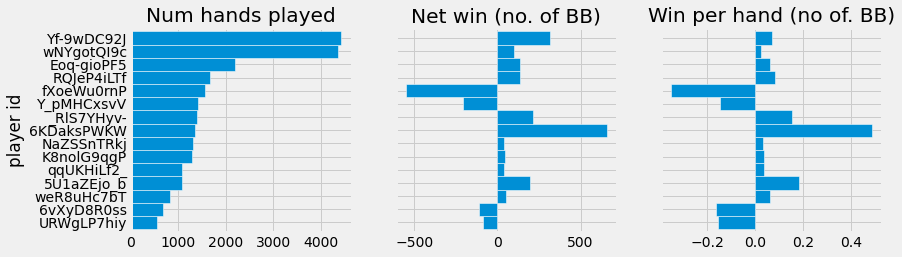

In [132]:
fig2, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
pl = pl.sort_values(by='num_hands_played')
pl15 = pl[-15:]
pl15['num_hands_played'].plot(ax=axes[0], title='Num hands played', kind='barh', width=1, ec='white')
(pl15['total_income'] - pl15['total_expenses']).plot(ax=axes[1], title='Net win (no. of BB)', kind='barh', ec='white', width=1)
pl15['win/hand'].plot(ax=axes[2], title='Win per hand (no of. BB)', kind='barh', ec='white', width=1)
axes[0].set_ylabel('player id')

In [164]:
class_s = pl.loc[pl['win/hand']>=.1].index
class_a = pl.loc[(pl['win/hand']>0) & (pl['win/hand']<.1)].index
class_b = pl.loc[(pl['win/hand']<=0) & (pl['win/hand']>-.1)].index
class_f = pl.loc[pl['win/hand']<=-.1].index

From this chart we can see that Loi @ 6k.. is a good player. We will try to find out how he plays!

**2. VPIP: Voluntarily Put In Pot & PFR: Pre-flop Raises**

VPIP tracks the percentage of hands in which a particular player voluntarily puts money into the pot preflop. VPIP increases when a player could fold but instead commits money to the pot preflop. This includes limping (merely calling the big blind), calling, and raising.

PFR tracks the percentage of hands in which a particular player makes a preflop raise when having the opportunity to fold or call instead. This includes reraises. By definition, PFR is a subset of VPIP. So we will plot the ratio PFR/VPIP to measure player's tendency.


In [133]:
# VPIP
_vpip = df.loc[(df['phase']=='Pre-flop') &
    (df['rank-P2']==1) &
    (df['action'].isin(['Bets/Raises', 'Calls']))
    ]['player_name'].value_counts(dropna=False)
_vpip.name = 'VPIP'
pl = pl.merge(_vpip, how='left', left_index=True, right_index=True)
pl['% VPIP'] = (pl['VPIP'] / pl['num_hands_played']).round(2)

# PFR / VPIP
_pfr = df.loc[(df['phase']=='Pre-flop') &
    (df['action']=='Bets/Raises')][['player_name', 'hand_num']].drop_duplicates()['player_name'].value_counts()
_pfr.name = 'PFR'
pl = pl.merge(_pfr, how='left', left_index=True, right_index=True)
pl['PFR / VPIP'] = (pl['PFR'] / pl['VPIP']).round(2)

Text(0.5, 1.0, 'Higher % VPIP (playing more loosely)\nis correlated with lower win/hand')

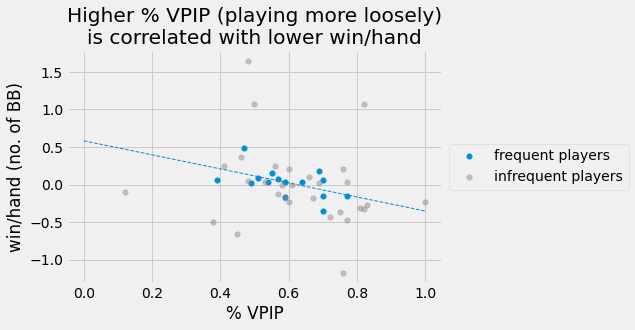

In [140]:
fig, ax = plt.subplots()
pl.iloc[-15:][['% VPIP', 'win/hand']].plot(kind='scatter', x='% VPIP', y='win/hand', ax=ax, s=30, label='frequent players')
pl.iloc[:-15][['% VPIP', 'win/hand']].plot(kind='scatter', x='% VPIP', y='win/hand', ax=ax, s=30, color='#8b8b8b', alpha=.5, label='infrequent players')


linear_regressor = LinearRegression()
linear_regressor.fit(pl.iloc[-15:]['% VPIP'].values.reshape(-1, 1), pl.iloc[-15:]['win/hand'].values.reshape(-1, 1))

X = np.linspace(0, 1, 1000).reshape(-1, 1)
y_pred = linear_regressor.predict(X)

ax.plot(X, y_pred, ls='--', lw=1)
ax.set_ylabel('win/hand (no. of BB)')

ax.legend(loc='center left', bbox_to_anchor=(1, .5),)

slope = round(linear_regressor.coef_[0][0],2)
ax.set_title('Higher % VPIP (playing more loosely)\nis correlated with lower win/hand')

Text(0.5, 1.0, 'Higher Pre-flop Raises (playing more aggressively)\nis correlated to higher win/hand')

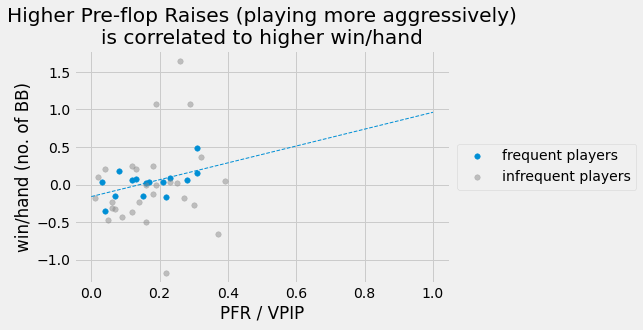

In [141]:
fig, ax = plt.subplots()
pl.iloc[-15:][['PFR / VPIP', 'win/hand']].plot(kind='scatter', x='PFR / VPIP', y='win/hand', ax=ax, s=30, label='frequent players')
pl.iloc[:-15][['PFR / VPIP', 'win/hand']].plot(kind='scatter', x='PFR / VPIP', y='win/hand', ax=ax, s=30, color='#8b8b8b', alpha=.5, label='infrequent players')


linear_regressor = LinearRegression()
linear_regressor.fit(pl.iloc[-15:]['PFR / VPIP'].values.reshape(-1, 1), pl.iloc[-15:]['win/hand'].values.reshape(-1, 1))

X = np.linspace(0, 1, 1000).reshape(-1, 1)
y_pred = linear_regressor.predict(X)

ax.plot(X, y_pred, ls='--', lw=1)
ax.set_ylabel('win/hand (no. of BB)')

ax.legend(loc='center left', bbox_to_anchor=(1, .5),)

slope = round(linear_regressor.coef_[0][0],2)
ax.set_title('Higher Pre-flop Raises (playing more aggressively)\nis correlated to higher win/hand')

It's clearer now that the winning players play fewer hands (lower % VPIP). But when they play, they are more aggressive with raisings!

**3. 3-BET and C-BET** (WIP)

In [ ]:
# _3bet = df.loc[(df['phase']=='Pre-flop') &
#     (df['action']=='Bets/Raises') &
#     (df['rank-A2']>1)]['player_name'].value_counts(dropna=False).fillna(0)
# _3bet.name = '3-BET'
# pl = pl.merge(_3bet, how='left', left_index=True, right_index=True)
# pl['% 3-BET'] = (pl['3-BET'] / pl['num_hands_played']).round(3)

In [ ]:
# pl.sort_values(by='% 3-BET', na_position='first')['% 3-BET'].plot(kind='barh', title='3-BET', width=1, ec='white')

**4. Wins and positions**

Good players play positions as well!
* EP: Early positions
* MP: Middle positions
* LP: Late positions

In [136]:
_pos = df.loc[df['action']=='Won'].pivot_table(
    index='player_name',
    columns='position_tag',
    values='hand_num',
    aggfunc=len,
    fill_value=0,
)
_pos['Total'] = _pos.sum(axis=1)

_pos.columns.name = None
for col in _pos.columns:
    if col != 'Total':
        _pos[f'Win at {col}'] = _pos[col] / _pos['Total']

_pos = _pos.round(3)
_pos_pct = _pos[[col for col in _pos.columns if col.startswith('Win at')]]

_pos_pct

,Win at Dealer,Win at EP,Win at LP,Win at MP
player_name,,,,
-aS8kTGcyL,0.053,0.263,0.263,0.421
24uSa0Jg9V,0.000,0.375,0.500,0.125
4-dr5_5Dj2,0.073,0.073,0.537,0.317
59Y3kR2GJJ,0.190,0.152,0.343,0.314
5U1aZEjo_b,0.172,0.166,0.357,0.306
6Jm3NPwGoJ,0.205,0.154,0.385,0.256
6KDaksPWKW,0.239,0.210,0.305,0.247
6vXyD8R0ss,0.180,0.148,0.418,0.254
87_zNFIhfU,0.167,0.167,0.667,0.000


In [173]:
# fig4, axes = plt.subplots(4, 1)
# _pos_pct.loc[class_s].plot(ax=axes[0], kind='barh', stacked=True, title='Share of winnings based on Position', width=1, ec='white')
# _pos_pct.loc[class_a].plot(ax=axes[1], kind='barh', stacked=True, width=1, ec='white')
# _pos_pct.loc[class_b].plot(ax=axes[2], kind='barh', stacked=True, width=1, ec='white')
# _pos_pct.loc[class_f].plot(ax=axes[3], kind='barh', stacked=True, width=1, ec='white')

# for ax in axes:
#     ax.get_yaxis().set_ticks([])

# axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.25))
# ax.set_ylabel('')